In [1]:
import torch
from torch import nn
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/global/homes/d/danieltm/.conda/envs/gnn4na/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Transformer Version

In [ ]:
def transformer_update(h, num_hidden, linear_q, linear_k, linear_v, softmax):

    # apply linear layers to compute query, key, and value
    q = linear_q(h)
    k = linear_k(h)
    v = linear_v(h)

    # compute dot product of query and key, and apply softmax
    dot_product = torch.matmul(q, k.transpose(2, 3)) / math.sqrt(num_hidden)
    attn_weights = softmax(dot_product)

    # apply dot product of attention weights and value
    attn_output = torch.matmul(attn_weights, v)
    
    return attn_output

In [2]:
def transformer_update_2(h, num_hidden, linear_q, linear_k, linear_v, softmax):

    # apply linear layers to compute query, key, and value
    q = linear_q(h)
    k = linear_k(h)
    v = linear_v(h)

    # compute dot product of query and key, and apply softmax
    dot_product = torch.matmul(k.transpose(2, 3), v)

    # apply dot product of attention weights and value
    attn_output = torch.matmul(v, dot_product)
    
    return attn_output

In [3]:
def run_transformer_update(num_nodes, num_hidden, batch_size = 1, attention_heads = 1, num_iters=1000):
    
    linear_q = nn.Linear(num_hidden, num_hidden).to("cuda")
    linear_k = nn.Linear(num_hidden, num_hidden).to("cuda")
    linear_v = nn.Linear(num_hidden, num_hidden).to("cuda")
    softmax = nn.Softmax(dim=-1).to("cuda")
    
    # Set pytorch random seed
    torch.manual_seed(0);
    h = torch.randn(batch_size, attention_heads, num_nodes, num_hidden).to("cuda")

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()

    for i in range(num_iters):
        transformer_update_2(h, num_hidden, linear_q, linear_k, linear_v, softmax)
        torch.cuda.synchronize()    

    end.record()
    torch.cuda.synchronize()

    return start.elapsed_time(end) / num_iters, torch.cuda.max_memory_allocated() / 1e6

In [6]:
num_nodes = 10
num_hidden = 10
batch_size = 1
attention_heads = 1

In [7]:
num_iters=10
timing, memory = run_transformer_update(int(num_nodes), int(num_hidden), batch_size, attention_heads, num_iters)
print(timing, "ms", memory, "MB")

0.1912832021713257 ms 0.006144 MB


In [8]:
torch.cuda.reset_max_memory_allocated()

/global/homes/d/danieltm/.conda/envs/gnn4na/lib/python3.9/site-packages/torch/cuda/memory.py:278: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [9]:
batch_size = 1
attention_heads = 1
num_iters=10
nums_nodes = []
nums_hidden = []
timings = []
memorys = []

for num_nodes in np.logspace(1, 4, num=10, base=10):
    for num_hidden in np.logspace(1, 4, num=10, base=10):
        print("-------\n", "N:", int(num_nodes), "H:", int(num_hidden))
        nums_hidden.append(num_hidden)
        nums_nodes.append(num_nodes)
        try:
            timing, memory = run_transformer_update(int(num_nodes), int(num_hidden), batch_size, attention_heads, num_iters)
            timings.append(timing)
            memorys.append(memory)
            print(timing, "ms", memory, "MB")
        except:
            print("OOM!")
            timings.append(np.nan)
            memorys.append(np.nan)

        torch.cuda.reset_max_memory_allocated()     

-------
 N: 10 H: 10
0.19107840061187745 ms 0.006144 MB
-------
 N: 10 H: 21
0.17704960107803344 ms 0.014848 MB
-------
 N: 10 H: 46
0.17100800275802613 ms 0.046592 MB
-------
 N: 10 H: 100
0.17377279996871947 ms 0.183808 MB
-------
 N: 10 H: 215
0.1802240014076233 ms 0.787968 MB
-------
 N: 10 H: 464
0.24104959964752198 ms 3.5456 MB
-------
 N: 10 H: 1000
0.23603200912475586 ms 16.215552 MB
-------
 N: 10 H: 2154
0.367305588722229 ms 75.640832 MB
-------
 N: 10 H: 4641
1.0400768280029298 ms 345.609216 MB
-------
 N: 10 H: 10000
3.4093761444091797 ms 1604.347392 MB
-------
 N: 21 H: 10
0.1756160020828247 ms 0.008704 MB
-------
 N: 21 H: 21
0.17172479629516602 ms 0.019968 MB
-------
 N: 21 H: 46
0.17018879652023317 ms 0.056832 MB
-------
 N: 21 H: 100
0.1716223955154419 ms 0.206848 MB
-------
 N: 21 H: 215
0.20725760459899903 ms 0.836608 MB
-------
 N: 21 H: 464
0.23490560054779053 ms 3.648 MB
-------
 N: 21 H: 1000
0.23454079627990723 ms 16.435712 MB
-------
 N: 21 H: 2154
0.3599008083

In [10]:
perf_df = pd.DataFrame({"num_nodes": nums_nodes, "num_hidden": nums_hidden, "timing": timings, "memory": memorys})

In [11]:
perf_df.to_csv("transformer_2_perf.csv")

## GNN Version

In [20]:
from torch_scatter import scatter_add
from torch_geometric import utils
import warnings
warnings.filterwarnings("ignore")

In [93]:
# Set pytorch random seed
torch.manual_seed(0);

In [26]:
def gnn_update(h, edges, linear_q, linear_k, linear_v):
    
    q = linear_q(h)
    k = linear_k(h)
    v = linear_v(h)

    incoming, outgoing = edges
    dot_product = (q[incoming]*k[outgoing]).sum(dim=-1) / math.sqrt(num_hidden)
    attn_weights = utils.softmax(dot_product, incoming, dim=0)

    attn_output = scatter_add(attn_weights[:, None]*v[outgoing], incoming, dim=0, dim_size=h.shape[0])

    return attn_output    

In [30]:
def run_gnn_update(num_nodes, num_hidden, batch_size = 1, attention_heads = 1, num_iters=1000):
    
    linear_q = nn.Linear(num_hidden, num_hidden).to("cuda")
    linear_k = nn.Linear(num_hidden, num_hidden).to("cuda")
    linear_v = nn.Linear(num_hidden, num_hidden).to("cuda")
    softmax = nn.Softmax(dim=-1).to("cuda")
    
    # Set pytorch random seed
    torch.manual_seed(0);
    h = torch.randn(num_nodes, num_hidden).to("cuda")
    edges = torch.stack(torch.meshgrid(torch.arange(num_nodes), torch.arange(num_nodes))).reshape(2, -1).to("cuda")

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()

    for i in range(num_iters):
        gnn_update(h, edges, linear_q, linear_k, linear_v)
        torch.cuda.synchronize()    

    end.record()
    torch.cuda.synchronize()

    return start.elapsed_time(end) / num_iters, torch.cuda.max_memory_allocated() / 1e6

In [31]:
num_nodes = 10
num_hidden = 10
batch_size = 1
attention_heads = 1

In [32]:
num_iters=10
timing, memory = run_gnn_update(int(num_nodes), int(num_hidden), batch_size, attention_heads, num_iters)
print(timing, "ms", memory, "MB")

1.682636833190918 ms 1.067008 MB


In [33]:
torch.cuda.reset_max_memory_allocated()

In [34]:
batch_size = 1
attention_heads = 1
num_iters=10
nums_nodes = []
nums_hidden = []
timings = []
memorys = []

for num_nodes in np.logspace(1, 4, num=10, base=10):
    for num_hidden in np.logspace(1, 4, num=10, base=10):
        print("-------\n", "N:", int(num_nodes), "H:", int(num_hidden))
        nums_hidden.append(num_hidden)
        nums_nodes.append(num_nodes)
        try:
            timing, memory = run_gnn_update(int(num_nodes), int(num_hidden), batch_size, attention_heads, num_iters)
            timings.append(timing)
            memorys.append(memory)
            print(timing, "ms", memory, "MB")
        except:
            print("OOM!")
            timings.append(np.nan)
            memorys.append(np.nan)

        torch.cuda.reset_max_memory_allocated()     

-------
 N: 10 H: 10
0.4926464080810547 ms 1.067008 MB
-------
 N: 10 H: 21
0.4080639839172363 ms 1.073664 MB
-------
 N: 10 H: 46
0.40755200386047363 ms 1.097728 MB
-------
 N: 10 H: 100
0.4055039882659912 ms 1.201152 MB
-------
 N: 10 H: 215
0.4005887985229492 ms 1.655808 MB
-------
 N: 10 H: 464
0.7161856174468995 ms 3.72736 MB
-------
 N: 10 H: 1000
0.5046271800994873 ms 13.832704 MB
-------
 N: 10 H: 2154
0.8545280456542969 ms 60.22912 MB
-------
 N: 10 H: 4641
1.2914688110351562 ms 267.099648 MB
-------
 N: 10 H: 10000
2.898944091796875 ms 1219.808256 MB
-------
 N: 21 H: 10
0.41246719360351564 ms 1.074176 MB
-------
 N: 21 H: 21
0.4074495792388916 ms 1.08288 MB
-------
 N: 21 H: 46
0.40570878982543945 ms 1.11104 MB
-------
 N: 21 H: 100
0.40755200386047363 ms 1.224704 MB
-------
 N: 21 H: 215
0.41216001510620115 ms 2.195968 MB
-------
 N: 21 H: 464
0.43089919090270995 ms 6.088704 MB
-------
 N: 21 H: 1000
0.4399104118347168 ms 19.52 MB
-------
 N: 21 H: 2154
0.6065152168273926 m

In [35]:
perf_df = pd.DataFrame({"num_nodes": nums_nodes, "num_hidden": nums_hidden, "timing": timings, "memory": memorys})

In [36]:
perf_df.to_csv("gnn_1_perf.csv")

## Compare Transformer and GNN

In [12]:
tran1_df = pd.read_csv("transformer_1_perf.csv")
tran2_df = pd.read_csv("transformer_2_perf.csv")
gnn_df = pd.read_csv("gnn_1_perf.csv")

In [ ]:
def plot_df(df):
    for num_nodes in [10, 100, 1000, 10000]:
        plt.plot()

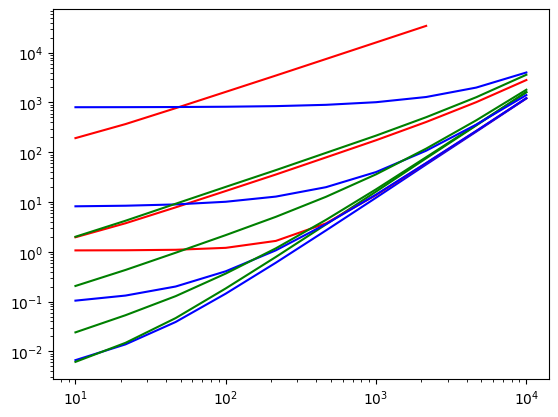

In [13]:
for num_nodes in [10, 100, 1000, 10000]:
    plt.plot(tran1_df[tran1_df.num_nodes == num_nodes].num_hidden, tran1_df[tran1_df.num_nodes == num_nodes].memory, c="b")
    plt.plot(tran2_df[tran2_df.num_nodes == num_nodes].num_hidden, tran2_df[tran2_df.num_nodes == num_nodes].memory, c="g")
    plt.plot(gnn_df[gnn_df.num_nodes == num_nodes].num_hidden, gnn_df[gnn_df.num_nodes == num_nodes].memory, c="r")

plt.yscale("log")
plt.xscale("log")

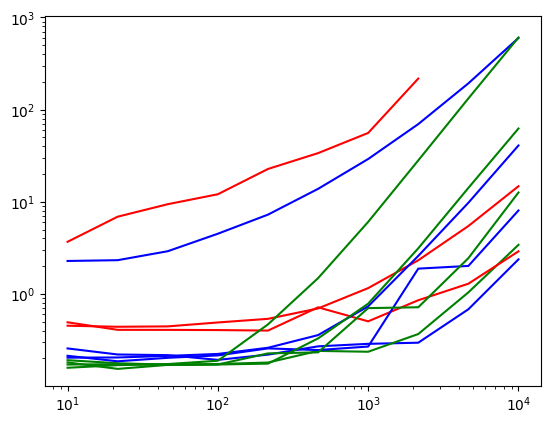

In [14]:
for num_nodes in [10, 100, 1000, 10000]:
    plt.plot(tran1_df[tran1_df.num_nodes == num_nodes].num_hidden, tran1_df[tran1_df.num_nodes == num_nodes].timing, c="b")
    plt.plot(tran2_df[tran2_df.num_nodes == num_nodes].num_hidden, tran2_df[tran2_df.num_nodes == num_nodes].timing, c="g")
    plt.plot(gnn_df[gnn_df.num_nodes == num_nodes].num_hidden, gnn_df[gnn_df.num_nodes == num_nodes].timing, c="r")

plt.yscale("log")
plt.xscale("log")